# 🤒 Deep Q-learning for Epidemic Mitigation

Daria Yakovchuk

Mariia Vidmuk

NOTE: to run the notebook one should create the following folders

- "config" - taken from the assignment.
- "epidemic_env" - taken from the assignment.
- "DQ_learning" - with the agent.py and model.py files (can be found at the end of the notebook)
  - "models" - to save the policy model

## Importing the relevant packages

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

from DQ_learning.model import DQN, DQN_Factorized
from DQ_learning.agent import Agent, ReplayMemory, DQNAgent, DQNAgent_Factorize

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn
from itertools import count
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Environment

Loading the environment object and the environment, defining the action and observation spaces.

['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


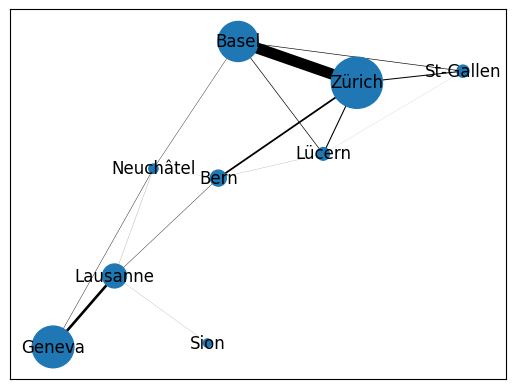

In [ ]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map
print(dyn.cities) # we added the encoding to ModelDynamics
dyn.draw_map()

sampled action : 3
Sampled observation


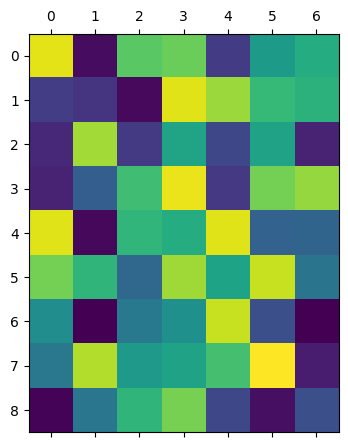

In [ ]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
print(f"sampled action : {action_space.sample()}")
print("Sampled observation")
plt.matshow(observation_space.sample()[0,:,:])
plt.show()

In [ ]:
SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

### Question 1.a) study the behavior of the model when epidemics are unmitigated.

Running the epidemic simulation for one episode (30 weeks), without epidemic mitigation (no action is
taken, i.e. all values in the action dictionary are set to False).

*Plots are below.*

In [ ]:
""" Running the simulation """
log = []
finished = False
obs, info = env.reset(2)
while not finished:
    action = 0 # no action is taken = do nothing + no agent
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break
    
""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

#### Plots:
Plot 1. A plot of variables $s^{[w]}_{total}$, $e^{[w]}_{total}$, $i^{[w]}_{total}$, $r^{[w]}_{total}$, $d^{[w]}_{total}$ over time, where time is measured in weeks and all the
variables share the y axis scaling.

Plot 2. A plot of variables $i^{[w]}_{total}$, $d^{[w]}_{total}$ over time, where time is measured in weeks and all the variables share the y axis scaling.

Plot 3. A set of plots of variables $i^{[w]}_{city}$, $d^{[w]}_{city}$ over time, where time is measured in weeks (one subplot per-city, variables share the y-scaling per-city).

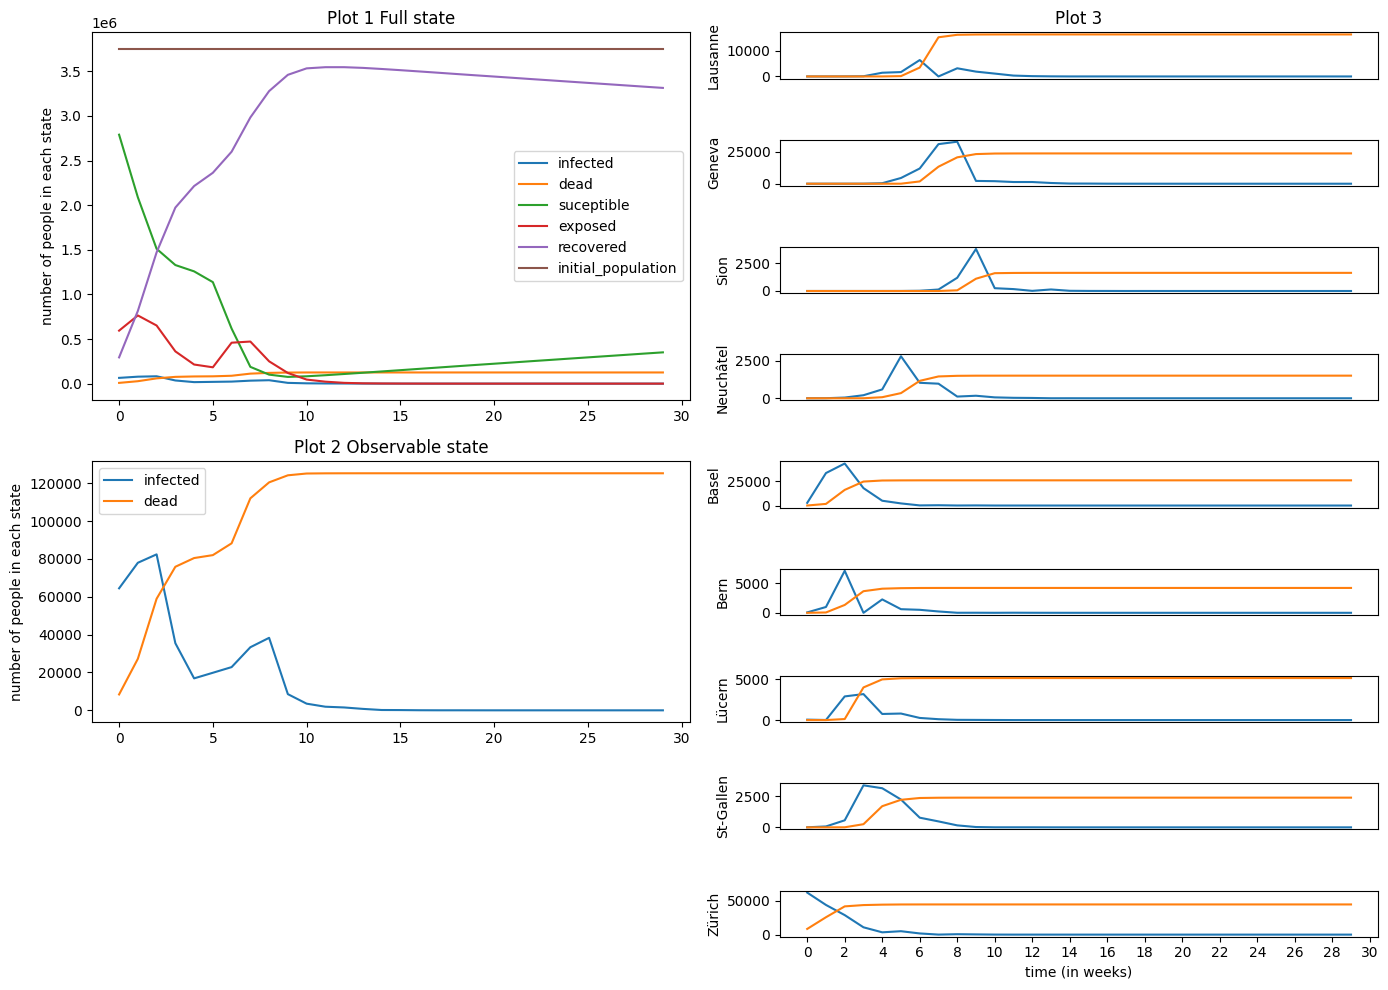

In [ ]:
from matplotlib.ticker import MultipleLocator

# from the tutorial
def plot_all(leftstate = True, leftobs =True, leftactions = True, right_per_city = True, order = [1, 2, 3, 4]):
    fig = plt.figure(figsize=(14,10))
    if leftstate: 
        ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
        [ax_leftstate.plot(y) for y in total.values()] # log-lin
        ax_leftstate.legend(total.keys())
        ax_leftstate.set_title(f'Plot {order[0]} Full state')
        ax_leftstate.set_ylabel('number of people in each state')
        
    if leftobs:
        ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
        [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
        ax_leftobs.legend(['infected','dead'])
        ax_leftobs.set_title(f'Plot {order[1]} Observable state')
        ax_leftobs.set_ylabel('number of people in each state')
    
    if leftactions:
        ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
        ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
        ax_leftactions.set_title(f'Plot {order[2]} Actions')
        ax_leftactions.set_yticks([0,1,2,3])
        ax_leftactions.set_yticklabels(list(actions.keys()))
        ax_leftactions.set_xlabel('time (in weeks)')
                
    if right_per_city:
        ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
        ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
        ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}
        [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
        [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
        [ax.set_ylabel(c) for c, ax in ax_right.items()]
        [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
        ax_right['Zürich'].set_xlabel('time (in weeks)')
        ax_right['Lausanne'].set_title(f'Plot {order[3]}')
        ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()
    
plot_all(leftstate = True, leftobs =True, leftactions = False, right_per_city = True, order = [1, 2, 0, 3])

## Professor Russo’s Policy

### Question 2.a) Implement Pr. Russo’s Policy

Running the epidemic simulation for one episode(30 weeks) using Pr. Russo’s Policy to pick actions.

*Plots are below.*

In [ ]:
# Implementation of Pr. Russo’s Policy (as a python class). 
class RussoAgent(Agent):
    def __init__(self,  env:Env):
        self.env = env
        self.count_confinement = 0
        self.dict = np.array([295000, 900000, 34978, 44531, 830000, 133115, 82000, 76213, 1354000]) 
        # dictionary for the population in each city
        # constant because the population in every city should be constant
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs):
        # this takes an observation and returns an action
        total = np.sum(np.array(obs[0, 0, :, -1]) * self.dict)/SCALE # calculation of the total amount of infected people 
        if total >= 20000 and self.count_confinement == 0: # Russo's condition 
            self.count_confinement = 1
            return 1
        if self.count_confinement == 4:
            self.count_confinement = 0
        elif self.count_confinement != 0:
            self.count_confinement += 1
            return 1
        return 0

In [ ]:
# running the simulation with Russo's agent
agent = RussoAgent(env)
log = []
finished = False
obs, info = env.reset(2)
agent.reset()
agent.epsilon = 0
while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

#### Plots:
Plot 1. A plot of variables $s^{[w]}_{total}$, $e^{[w]}_{total}$, $i^{[w]}_{total}$, $r^{[w]}_{total}$, $d^{[w]}_{total}$ over time, where time is measured in weeks and all the
variables share the y axis scaling.

Plot 2. A plot of variables $i^{[w]}_{total}$, $d^{[w]}_{total}$ over time, where time is measured in weeks and all the variables share the y axis scaling.

Plot 3. A set of plots of variables $i^{[w]}_{city}$, $d^{[w]}_{city}$ over time, where time is measured in weeks (one subplot per-city, variables share the y-scaling per-city).

Plot 4. A plot of the action taken by the policy over time (whether the policy chooses to confine or not).

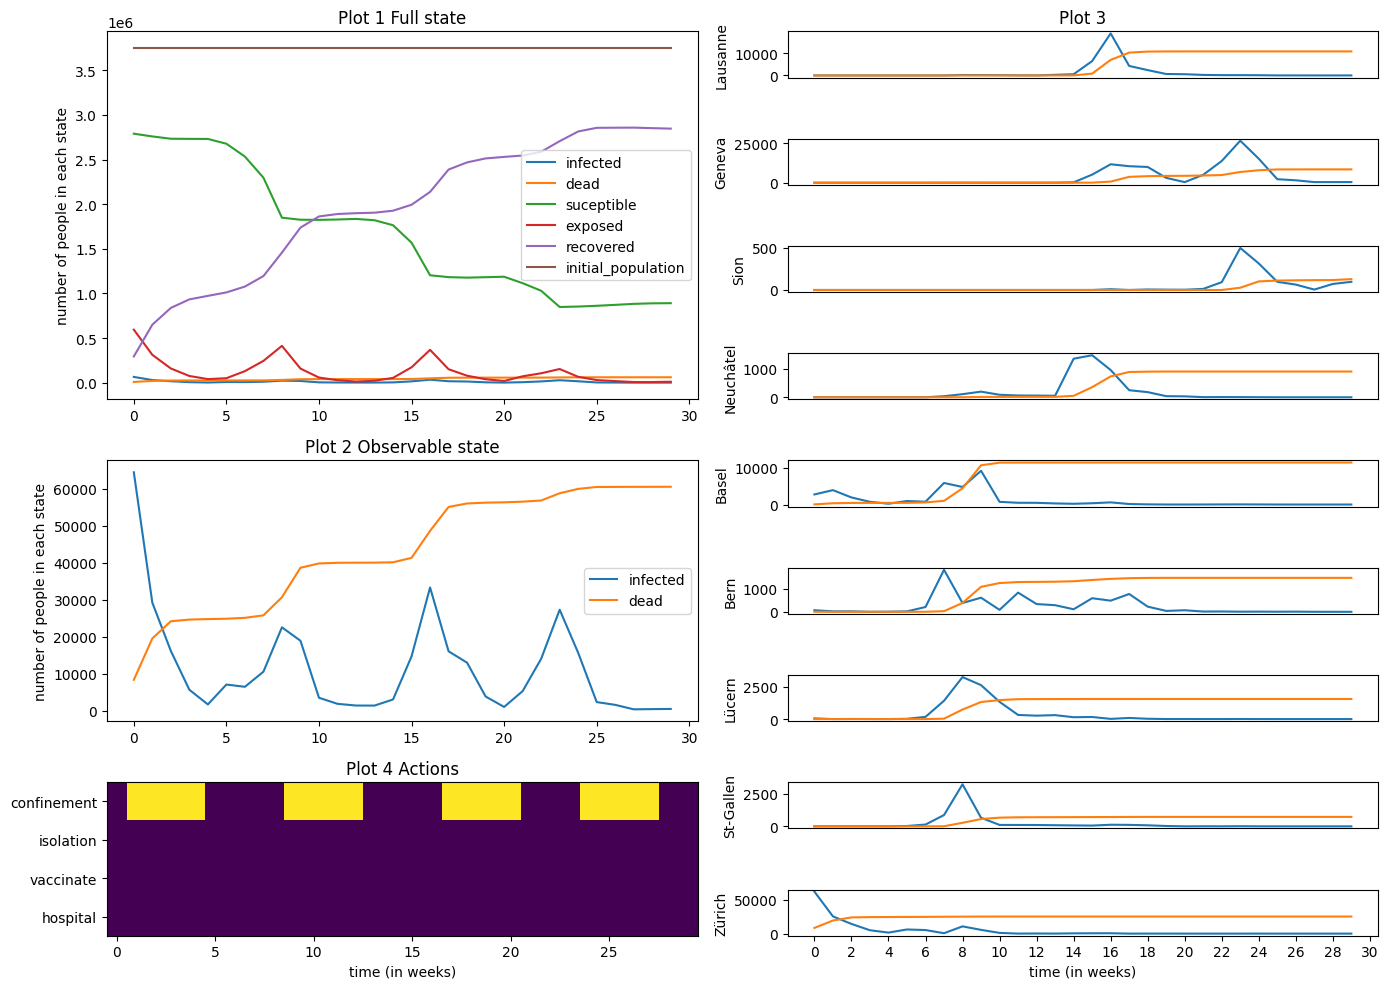

In [ ]:
plot_all(leftstate = True, leftobs =True, leftactions = True, right_per_city = True, order = [1, 2, 4, 3])

### Question 2.b) Evaluate Pr. Russo’s Policy
Evaluation procedure: 
- run 50 simulation episodes where actions are chosen from Pr. Russo’s Policy 
- for each episode, save the following values:
    1. the number of total confined days $N_{confinement}$ = 7 · number of confined weeks,
    2. the cumulative reward (the sum of all rewards collected during the episode) $R_{cumulative} = \sum_{
i∈[0,...,30]} R[i]$.
    3. the number of total deaths $N_{deaths} = d^{[30]}_{total}$

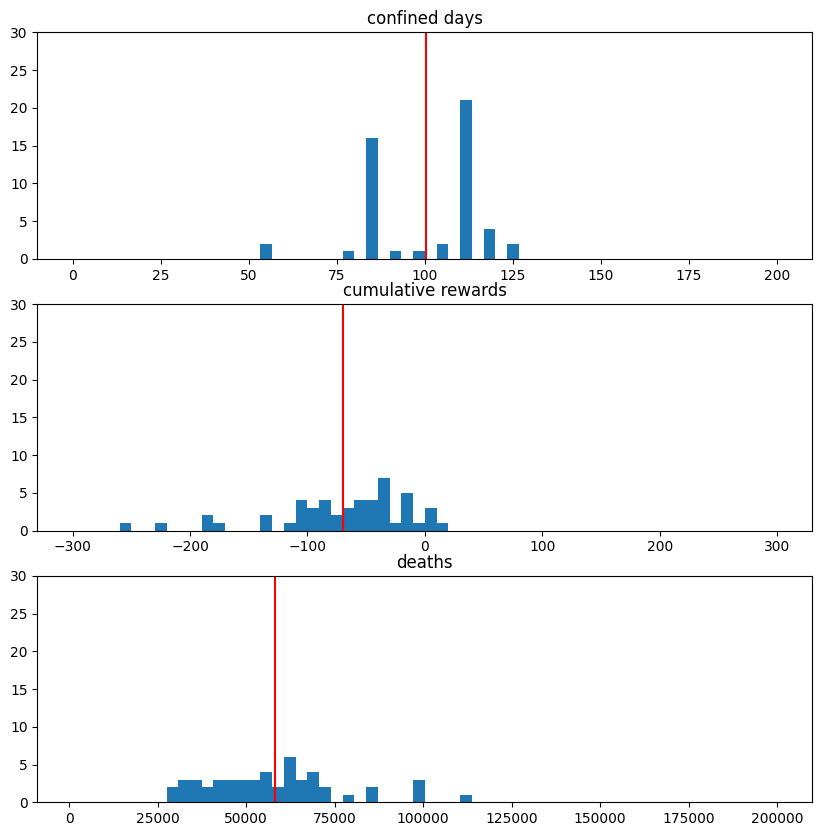

In [ ]:
agent_russo = RussoAgent(env)

def hist_avg(ax, data, title):
    ymax = 30
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards':
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title')
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
    
def run_experiment(agent, num_episodes):
    fig, ax = plt.subplots(3, 1, figsize=(10,10))
    rewards = []
    confine = []
    death = []
    for trace in range(num_episodes):
        torch.manual_seed(0)
        torch.use_deterministic_algorithms(True)
        log = []
        seed = trace # dealing with sequence of random seeds
        finished = False
        obs, info = env.reset(seed)
        agent.reset()
        n_weeks_confined = 0
        R_sum = 0
        while not finished:
            action = agent.act(obs)
            obs, R, finished, info = env.step(action)
            log.append(info) # save the information dict for logging
            R_sum += R[0][0]
            if action == 1:
                n_weeks_confined += 1
            if finished:
                break
        """ Parse the logs """
        total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
        confine.append(7 * n_weeks_confined) 
        rewards.append(R_sum)
        death.append((total['dead'][-1]))

    hist_avg(ax[0], confine, "confined days")
    hist_avg(ax[1], rewards, "cumulative rewards")
    hist_avg(ax[2], death, "deaths")

run_experiment(agent_russo, 50)

## A Deep Q-learning approach

### Question 3.a) implementing Deep Q-Learning

Implementing and training the Deep Q-Learning agent $\pi_{DQN}$ for 500 training episodes, with $ϵ$ = 0.7.

*Plots of the training trace and the eval trace are below.*

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
action_space_binary     =   spaces.Discrete(2)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

def observation_preprocessor_dqn(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    return torch.pow(torch.Tensor(np.stack((infected, dead))).unsqueeze(0), 1/4)

env_dqn = Env(dyn,
            action_space=action_space_binary,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor_dqn,
            )

In [ ]:
agent = DQNAgent(env_dqn, DQN)
log_eval = []
log_train = []
for train in range(3): #  three full training processe
  agent.reset() # reset agent 
  print("Run:", train + 1)
  for i_episode in range(1, 501):
      torch.manual_seed(0)
      torch.use_deterministic_algorithms(True)
      R_total = 0
      state, info = env_dqn.reset(i_episode)
      state = state.flatten()
      state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
      update_target = False
      if i_episode%5 ==0: # (fully) update the target network every 5 episodes
          update_target = True
      for t in count():
          action = agent.act(state, i_episode)
          observation, reward, terminated, truncated = env_dqn.step(action.item())
          R_total += reward[0][0]
          reward = torch.tensor([reward], device=device)
          done = terminated or truncated
          if terminated:
              next_state = None
              break
          else:
              next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
          # Store the transition in memory
          agent.memory.push(state, action, next_state, reward)
          # Move to the next state
          state = next_state
          # Perform one step of the optimization (on the policy network)
          agent.optimize_model(update_target)
          # Soft update of the target network's weights
          # θ′ ← τ θ + (1 −τ )θ′ let τ = 0.005
          target_net_state_dict = agent.target_net.state_dict()
          policy_net_state_dict = agent.policy_net.state_dict()
          for key in policy_net_state_dict:
              target_net_state_dict[key] = policy_net_state_dict[key]*0.005 + target_net_state_dict[key]*(1-0.005)
          agent.target_net.load_state_dict(target_net_state_dict)
      log_train.append(R_total)
      # 20 episode evaluation procedure
      if i_episode%50 == 0:
          print(i_episode)
          R_total = []
          rewards = 0
          agent.epsilon = 0 # stop exploration
          for i in range(20):
              torch.manual_seed(0)
              torch.use_deterministic_algorithms(True)
              state, info = env_dqn.reset(seed = i)
              state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
              for t in count():
                  action = agent.act(state, i_episode)
                  observation, reward, terminated, truncated = env_dqn.step(action.item())
                  R_total.append(reward[0][0])
                  reward = torch.tensor([reward], device=device)
                  done = terminated or truncated
                  if terminated:
                      next_state = None
                      break
                  else:
                      next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
                  state = next_state
          if np.mean(R_total) >= rewards:
              rewards = np.mean(R_total)
              # saving the best model
              agent.save_model("/content/DQ_learning/models/3_a.pt")
          agent.epsilon = 0.7
          log_eval.append(np.mean(R_total))

Run: 1
50
100
150
200
250
300
350
400
450
500
Run: 2
50
100
150
200
250
300
350
400
450
500
Run: 3
50
100
150
200
250
300
350
400
450
500


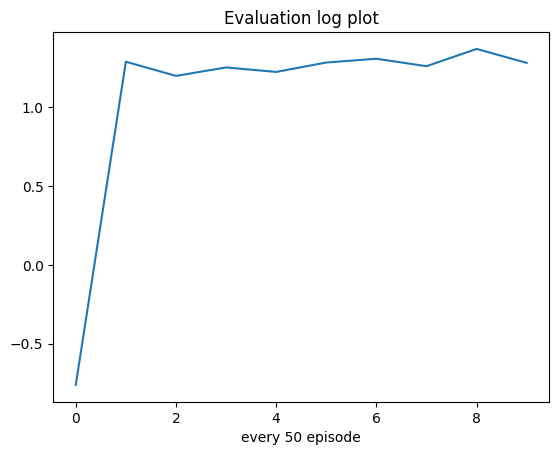

[-0.76164174  1.2889122   1.1989708   1.2526323   1.2241966   1.2838358
  1.3077532   1.2604619   1.3700987   1.2816974 ]


In [ ]:
eval_log = np.array(log_eval).reshape(3, int(len(log_eval)/3)).mean(axis = 0)
plt.plot(eval_log)
plt.title("Evaluation log plot")
plt.xlabel("every 50 episode")
plt.show();
print(eval_log)

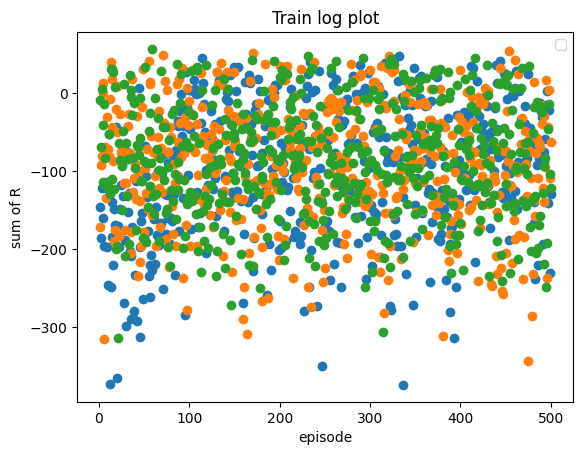

In [ ]:
train_log = np.array(log_train).reshape(3, int(len(log_train)/3))
plt.scatter(y = train_log[0], x = np.arange(1, 501))
plt.scatter(y = train_log[1], x = np.arange(1, 501))
plt.scatter(y = train_log[2], x = np.arange(1, 501))
plt.legend()
plt.title("Train log plot")
plt.xlabel("episode")
plt.ylabel("sum of R")
plt.show();

In [ ]:
# Evaluation on best policy to plot the last episode
agent.load_model("/content/DQ_learning/models/3_a.pt")
log_eval = []
log = [] 
for i_episode in range(1, 4):
    torch.manual_seed(0)
    torch.use_deterministic_algorithms(True)
    state, info = env_dqn.reset(i_episode)
    R_total = []
    agent.epsilon = 0
    state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = agent.act(state, i_episode)
        observation, reward, terminated, truncated = env_dqn.step(action.item())
        if i_episode == 3:
          log.append(truncated)
        R_total.append(reward[0][0])
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
            break
        else:
            next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
        state = next_state
    log_eval.append(np.mean(R_total))

total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

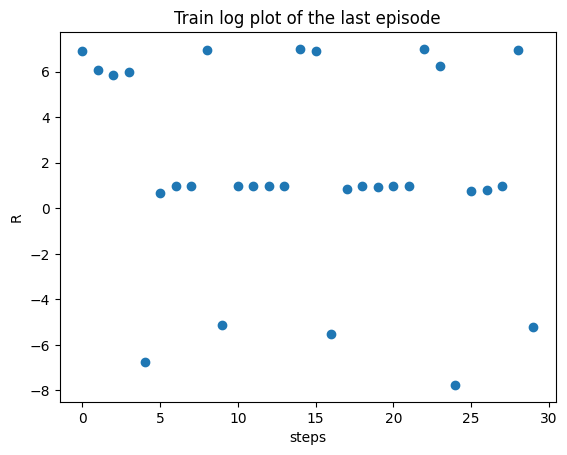

In [ ]:
plt.scatter(x = np.arange(len(R_total)), y = R_total)
plt.title("Train log plot of the last episode")
plt.xlabel("steps")
plt.ylabel("R")
plt.show();

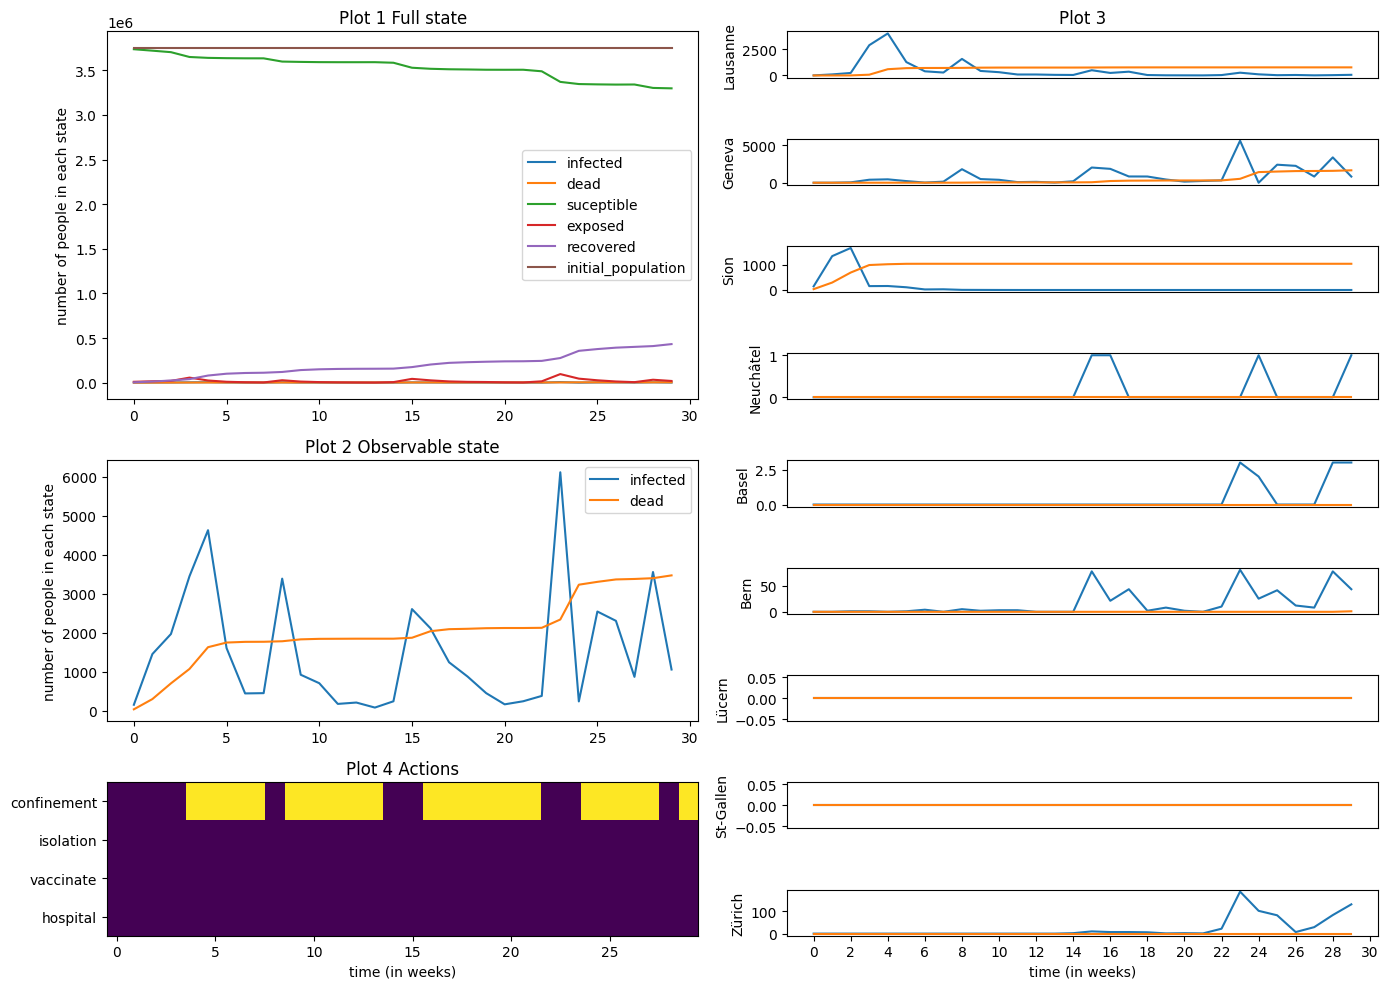

In [ ]:
plot_all(leftstate = True, leftobs =True, leftactions = True, right_per_city = True, order = [1, 2, 4, 3])

### Question 3.b) decreasing exploration

Implementing and training Deep Q-Learning agent for 500 training episodes with decreasing $ϵ$.

*Plots of the training trace and the eval trace are below.*

In [ ]:
agent = DQNAgent(env_dqn, DQN)
log_eval = []
log_train = []
decreasing = True
for train in range(3):
  agent.reset()
  print("Run:", train + 1)
  for i_episode in range(1, 501):
      R_total = 0
      torch.manual_seed(0)
      torch.use_deterministic_algorithms(True)
      state, info = env_dqn.reset(i_episode)
      state = state.flatten()
      state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
      update_target = False
      if i_episode%5 ==0:
          update_target = True
      for t in count():
          action = agent.act(state, i_episode, decreasing)
          observation, reward, terminated, truncated = env_dqn.step(action.item())
          R_total += reward[0][0]
          reward = torch.tensor([reward], device=device)
          done = terminated or truncated
          if terminated:
              next_state = None
              break
          else:
              next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
          agent.memory.push(state, action, next_state, reward)
          state = next_state
          agent.optimize_model(update_target)
          target_net_state_dict = agent.target_net.state_dict()
          policy_net_state_dict = agent.policy_net.state_dict()
          for key in policy_net_state_dict:
              target_net_state_dict[key] = policy_net_state_dict[key]*0.005 + target_net_state_dict[key]*(1-0.005)
          agent.target_net.load_state_dict(target_net_state_dict)
      log_train.append(R_total)
      # Evaluation
      if i_episode%50 == 0:
          print(i_episode)
          R_total = []
          rewards = 0
          agent.epsilon = 0
          for i in range(20):
              torch.manual_seed(0)
              torch.use_deterministic_algorithms(True)
              state, info = env_dqn.reset(seed = i)
              state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
              for t in count():
                  action = agent.act(state, i_episode)
                  observation, reward, terminated, truncated = env_dqn.step(action.item())
                  R_total.append(reward[0][0])
                  reward = torch.tensor([reward], device=device)
                  done = terminated or truncated
                  if terminated:
                      next_state = None
                      break
                  else:
                      next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
                  state = next_state
          if np.mean(R_total) >= rewards:
              rewards = np.mean(R_total)
              # saving the best model
              agent.save_model("/content/DQ_learning/models/3_b.pt")
          agent.epsilon = 0.7
          log_eval.append(np.mean(R_total))

Run: 1
50
100
150
200
250
300
350
400
450
500
Run: 2
50
100
150
200
250
300
350
400
450
500
Run: 3
50
100
150
200
250
300
350
400
450
500


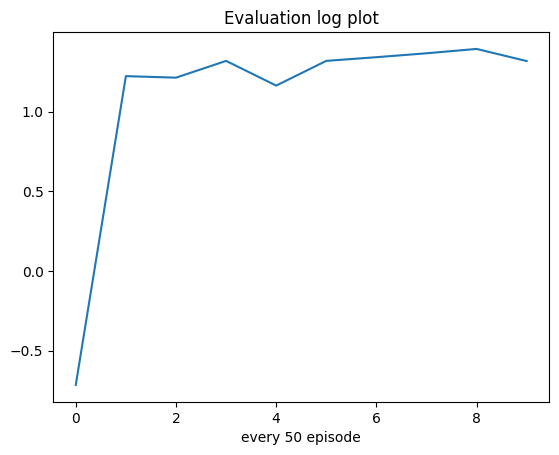

[-0.71409065  1.2223954   1.2127872   1.3179886   1.1630363   1.3180581
  1.3411297   1.3656105   1.3930262   1.3168837 ]


In [ ]:
eval_log = np.array(log_eval).reshape(3, int(len(log_eval)/3)).mean(axis = 0)
plt.plot(eval_log)
plt.title("Evaluation log plot")
plt.xlabel("every 50 episode")
plt.show();
print(eval_log)

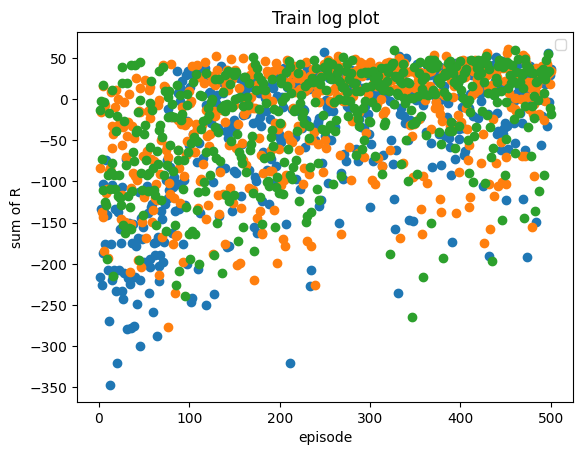

In [ ]:
train_log = np.array(log_train).reshape(3, int(len(log_train)/3))
plt.scatter(y = train_log[0], x = np.arange(1, 501))
plt.scatter(y = train_log[1], x = np.arange(1, 501))
plt.scatter(y = train_log[2], x = np.arange(1, 501))
plt.legend()
plt.title("Train log plot")
plt.xlabel("episode")
plt.ylabel("sum of R")
plt.show();

In [ ]:
# Evaluation on best policy to plot the last episode

agent.load_model("/content/DQ_learning/models/3_b.pt")
log_eval = []
log = []
for i_episode in range(1, 4):
    torch.manual_seed(0)
    torch.use_deterministic_algorithms(True)
    state, info = env_dqn.reset(i_episode)
    R_total = []
    agent.epsilon = 0
    state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = agent.act(state, i_episode)
        observation, reward, terminated, truncated = env_dqn.step(action.item())
        if i_episode == 2:
          log.append(truncated)
        R_total.append(reward[0][0])
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
            break
        else:
            next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
        state = next_state
    log_eval.append(np.mean(R_total))

total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

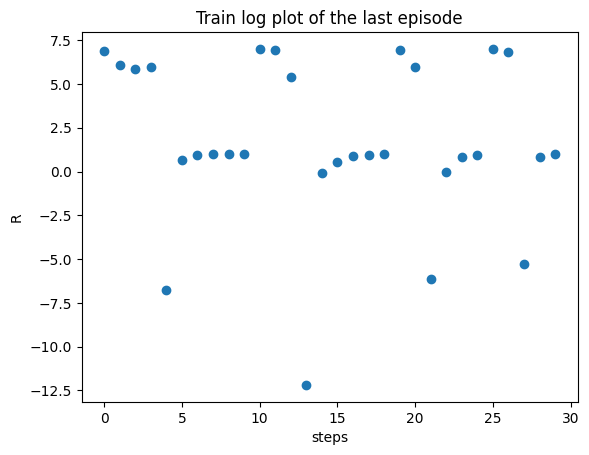

In [ ]:
plt.scatter(x = np.arange(len(R_total)), y = R_total)
plt.title("Train log plot of the last episode")
plt.xlabel("steps")
plt.ylabel("R")
plt.show();

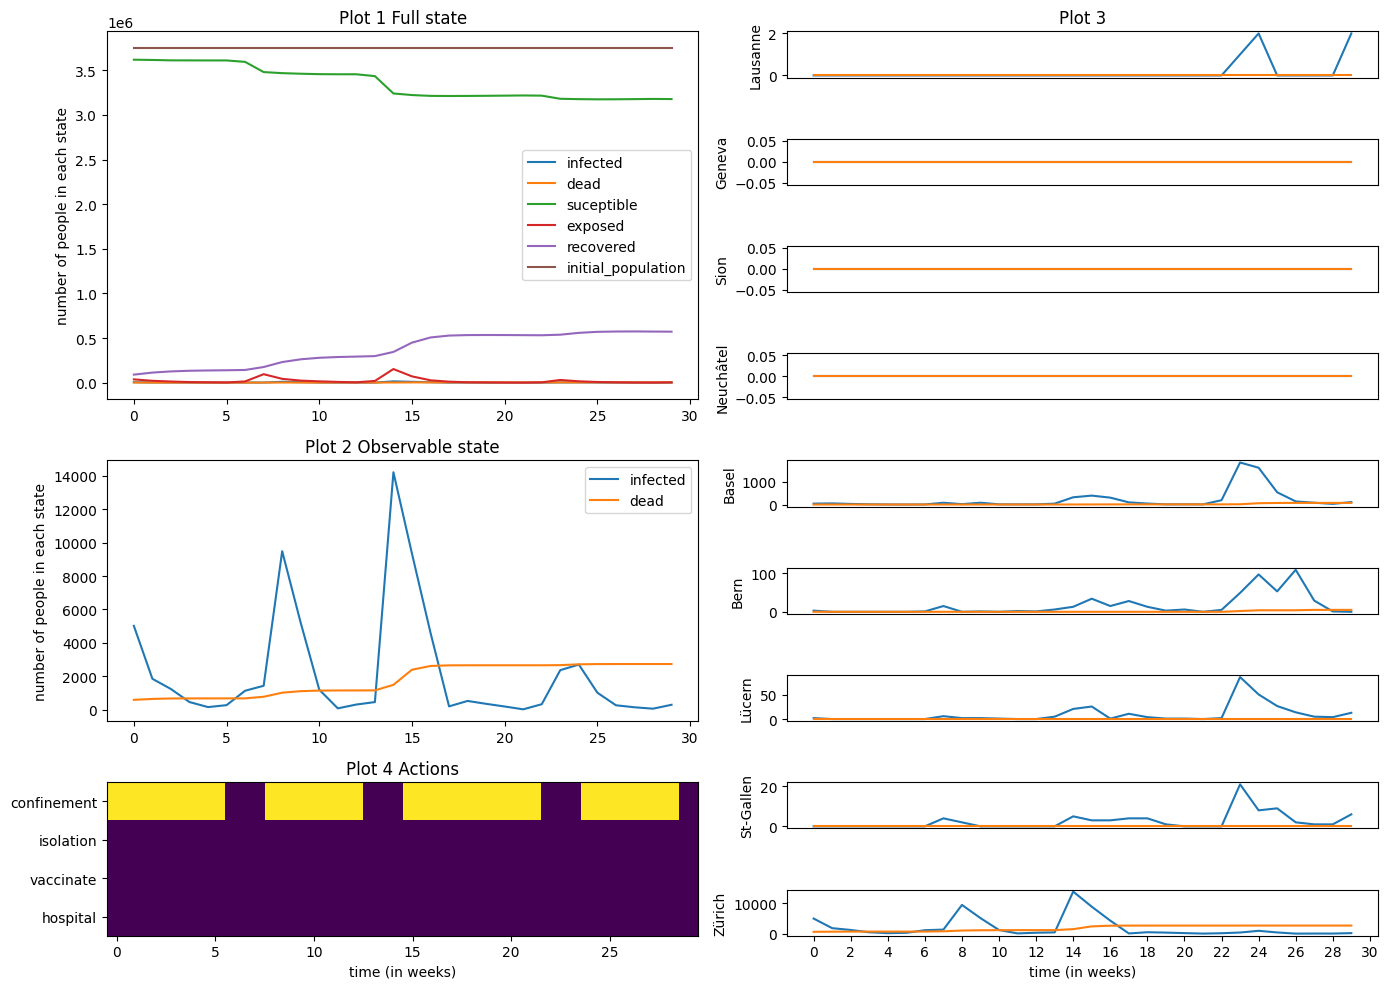

In [ ]:
plot_all(leftstate = True, leftobs =True, leftactions = True, right_per_city = True, order = [1, 2, 4, 3])

### Question 3.c) evaluate the best performing policy against Pr. Russo’s policy
Running the best performing policy $\pi^{∗}_{DQN}$ through the evaluation code in 2.b), generating the same histogram plots and comparing the results.

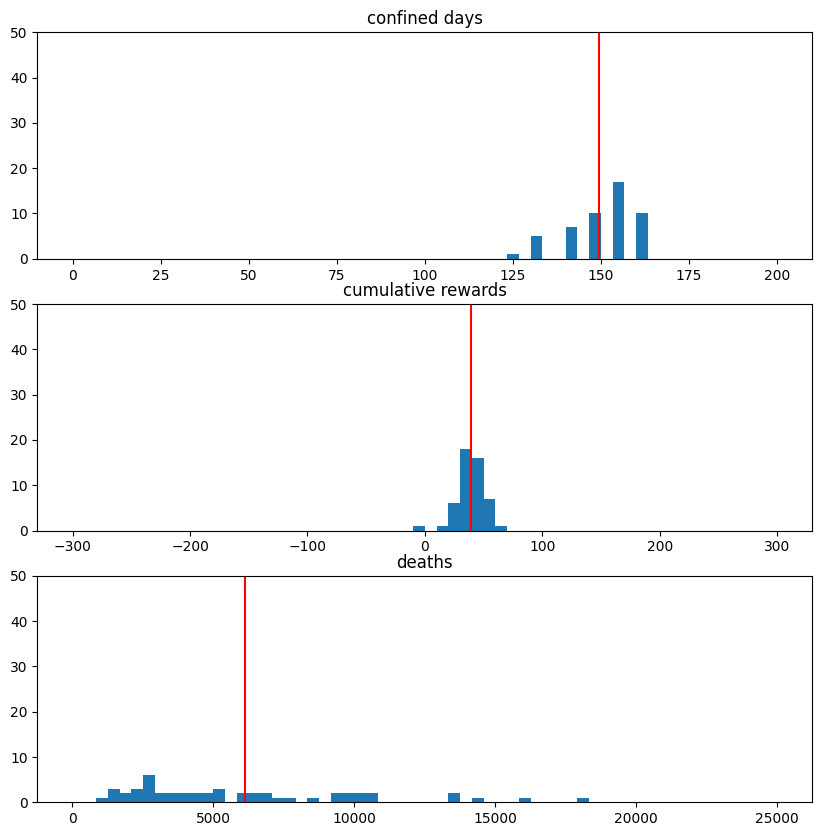

In [ ]:
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (10,25000)
    elif title == 'cumulative rewards':
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title')
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
    
def run_experiment(agent1, num_episodes, env):
    fig, ax = plt.subplots(3, 1, figsize=(10,10))
    rewards = []
    confine = []
    death = []
    agent1.epsilon = 0
    for trace in range(num_episodes):
        torch.manual_seed(0)
        torch.use_deterministic_algorithms(True)
        log = []
        seed = trace
        finished = False
        obs, info = env.reset(seed)
        obs = torch.tensor(obs.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
        n_weeks_confined = 0
        R_sum = 0
        while not finished:
            action = agent1.act(obs, trace)
            obs, R, finished, info = env.step(action)
            log.append(info) # save the information dict for logging
            R_sum += R[0][0]
            if dyn.get_action()["confinement"]:
              n_weeks_confined += 1
            if finished:
                break
            obs = torch.tensor(obs.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
        """ Parse the logs """
        total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
        confine.append(7 * n_weeks_confined) 
        rewards.append(R_sum)
        death.append(total['dead'][-1])
    hist_avg(ax[0], confine, "confined days")
    hist_avg(ax[1], rewards, "cumulative rewards")
    hist_avg(ax[2], death, "deaths")

agent.load_model("/content/DQ_learning/models/3_b.pt") 
run_experiment(agent, 50, env_dqn)

## Dealing with a more complex action Space

### Question 4.1.a) (Theory) Action space design

**Why would one want to use such an action-observation space as the one above, rather than directly compute Q(s, a) for each action? Discuss, the impact on network architecture and on training.**

Having such action space we might take several actions at the same time and not change the network output. But this can make the learning process slower and more unstable. 

The change of the observation space, which includes the current state of each action as an observation, enforce us to have a larger input layer size. 

### Question 4.1.b) Toggle-action-space multi-action policy training

Implementation of the toggled-action and observation spaces and training Deep Q-Learning agent on it. 

*Plots of the training and evaluation traces (average across 3 training runs) are below.*

In [ ]:
action_space_toggle      =  spaces.Discrete(5)
observation_space_toggle =  spaces.Box( low=0,
                                    high=1,
                                    shape=(3, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

def action_preprocessor_toggle(a:torch.Tensor, dyn:ModelDynamics):
    action_toggle = { # DO NOTHING
        'confinement': dyn.get_action()['confinement'], 
        'isolation': dyn.get_action()['isolation'], 
        'hospital': dyn.get_action()['hospital'], 
        'vaccinate': dyn.get_action()['vaccinate'],
    }

    if a == ACTION_CONFINE:
        action_toggle['confinement'] = not action_toggle['confinement']
    elif a == ACTION_ISOLATE:
        action_toggle['isolation'] = not action_toggle['isolation']
    elif a == ACTION_VACCINATE:
        action_toggle['vaccinate'] = not action_toggle['vaccinate']
    elif a == ACTION_HOSPITAL:
        action_toggle['hospital'] = not action_toggle['hospital']
    
    return action_toggle

def observation_preprocessor_toggle(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    obs_ = np.concatenate((
        np.ones((1, 7)) * int((dyn.get_action()['confinement'])),
        np.ones((1, 7)) * int((dyn.get_action()['isolation'])),
        np.ones((1, 7)) * int((dyn.get_action()['hospital'])),
        np.ones((1, 7)) * int((dyn.get_action()['vaccinate'])), 
        np.zeros((5, 7))
    )) 
    return torch.pow(torch.Tensor(np.stack((infected, dead, obs_))).unsqueeze(0), 1/4)

env_toggle = Env(  dyn,
            action_space=action_space_toggle,
            observation_space=observation_space_toggle,
            action_preprocessor=action_preprocessor_toggle,
            observation_preprocessor=observation_preprocessor_toggle,
            )

In [ ]:
agent = DQNAgent(env_toggle, DQN, lr = 1e-5)
log_eval = []
log_train = []
decreasing = True
for train in range(3):
  agent.reset()
  print("Run:", train + 1)
  for i_episode in range(1, 501):
      R_total = 0
      torch.manual_seed(0)
      torch.use_deterministic_algorithms(True)
      state, info = env_toggle.reset(i_episode)
      state = state.flatten()
      state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
      update_target = False
      if i_episode%5 ==0:
          update_target = True
      for t in count():
          action = agent.act(state, i_episode, decreasing)
          observation, reward, terminated, truncated = env_toggle.step(action.item())
          R_total += reward[0][0]
          reward = torch.tensor([reward], device=device)
          done = terminated or truncated
          if terminated:
              next_state = None
              break
          else:
              next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
          agent.memory.push(state, action, next_state, reward)
          state = next_state
          agent.optimize_model(update_target)
          target_net_state_dict = agent.target_net.state_dict()
          policy_net_state_dict = agent.policy_net.state_dict()
          for key in policy_net_state_dict:
              target_net_state_dict[key] = policy_net_state_dict[key]*0.005 + target_net_state_dict[key]*(1-0.005)
          agent.target_net.load_state_dict(target_net_state_dict)
      log_train.append(R_total)
      # Evaluation
      if i_episode%50 == 0:
          print(i_episode)
          R_total = []
          rewards = -100
          agent.epsilon = 0
          for i in range(20):
              torch.manual_seed(0)
              torch.use_deterministic_algorithms(True)
              state, info = env_toggle.reset(seed = i)
              state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
              for t in count():
                  action = agent.act(state, i_episode)
                  observation, reward, terminated, truncated = env_toggle.step(action.item())
                  R_total.append(reward[0][0])
                  reward = torch.tensor([reward], device=device)
                  done = terminated or truncated
                  if terminated:
                      next_state = None
                      break
                  else:
                      next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
                  state = next_state
          if np.mean(R_total) >= rewards:
              rewards = np.mean(R_total)
              # saving the best model
              agent.save_model("/content/DQ_learning/models/4_1_b.pt")
          agent.epsilon = 0.7
          log_eval.append(np.mean(R_total))

Run: 1
50
100
150
200
250
300
350
400
450
500
Run: 2
50
100
150
200
250
300
350
400
450
500
Run: 3
50
100
150
200
250
300
350
400
450
500


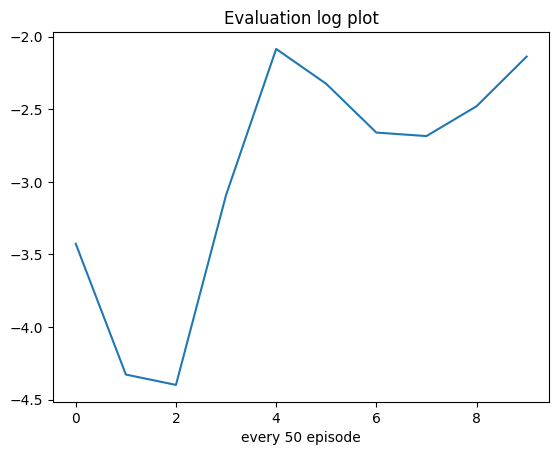

[-3.4264727 -4.3263273 -4.3977714 -3.0908508 -2.0853016 -2.325756
 -2.661107  -2.6850634 -2.4796546 -2.1379435]


In [ ]:
eval_log_toggle = np.array(log_eval).reshape(3, int(len(log_eval)/3)).mean(axis = 0)
plt.plot(eval_log_toggle)
plt.title("Evaluation log plot")
plt.xlabel("every 50 episode")
plt.show();
print(eval_log_toggle)

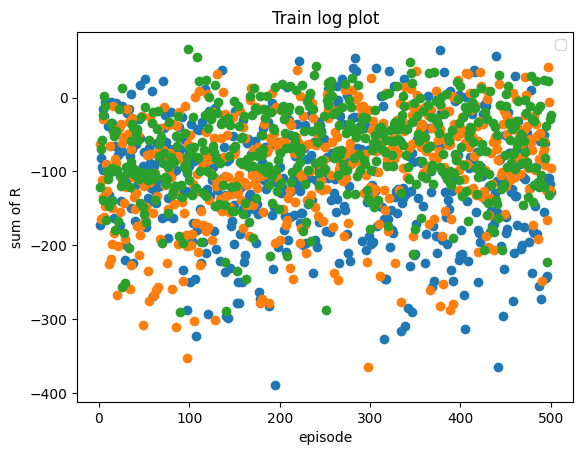

In [ ]:
train_log_toggle = np.array(log_train).reshape(3, int(len(log_train)/3))
plt.scatter(y = train_log_toggle[0], x = np.arange(1, 501))
plt.scatter(y = train_log_toggle[1], x = np.arange(1, 501))
plt.scatter(y = train_log_toggle[2], x = np.arange(1, 501))
plt.legend()
plt.title("Train log plot")
plt.xlabel("episode")
plt.ylabel("sum of R")
plt.show();

In [ ]:
agent.load_model("/content/DQ_learning/models/4_1_b.pt")
log_eval = []
log = []
for i_episode in range(1, 4):
    torch.manual_seed(0)
    torch.use_deterministic_algorithms(True)
    state, info = env_toggle.reset(i_episode)
    state = state.flatten()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    R_total = []
    agent.epsilon = 0
    for t in count():
        action = agent.act(state, i_episode)
        observation, reward, terminated, truncated = env_toggle.step(action.item())
        if i_episode == 2:
          log.append(truncated)
        R_total.append(reward[0][0])
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
            break
        else:
            next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
        state = next_state
    log_eval.append(np.mean(R_total))

total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

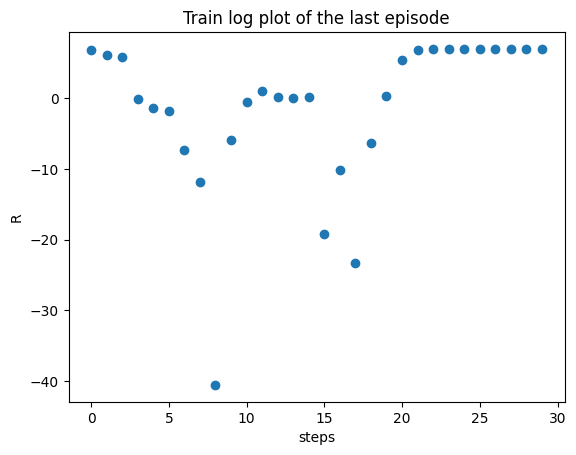

In [ ]:
plt.scatter(x = np.arange(len(R_total)), y = R_total)
plt.title("Train log plot of the last episode")
plt.xlabel("steps")
plt.ylabel("R")
plt.show();

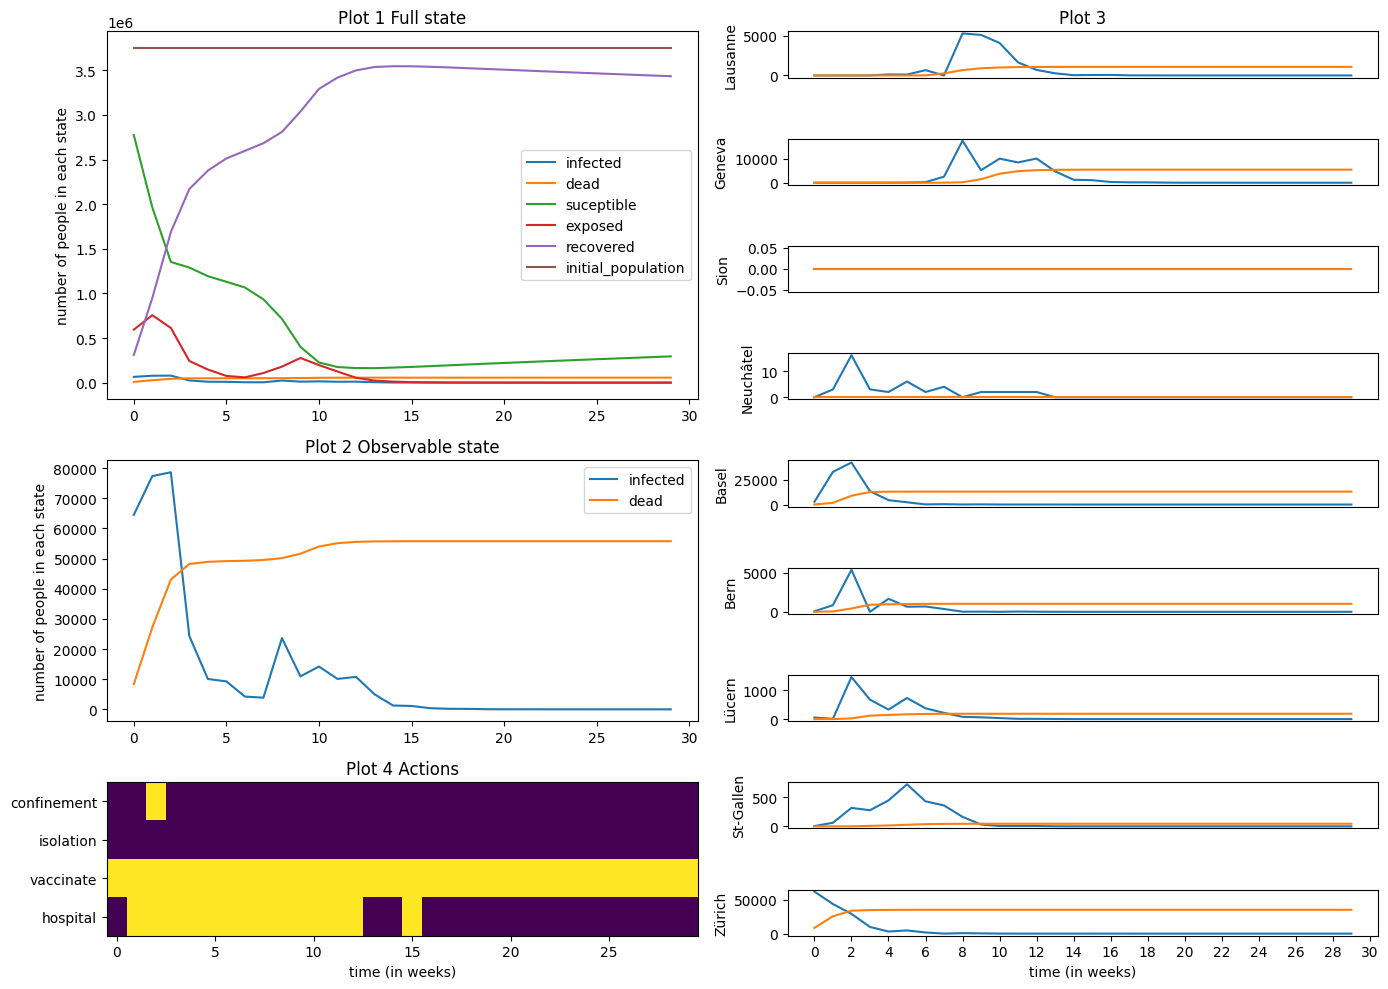

In [ ]:
plot_all(leftstate = True, leftobs =True, leftactions = True, right_per_city = True, order = [1, 2, 4, 3])

### Question 4.1.c) Toggle-action-space multi-action policy evaluation

Evaluation of the $\pi^{∗}_{Toggle}$ policy trained in question 4.1.b), using the evaluation procedure that you previously defined.

*Plot of the histograms are below*

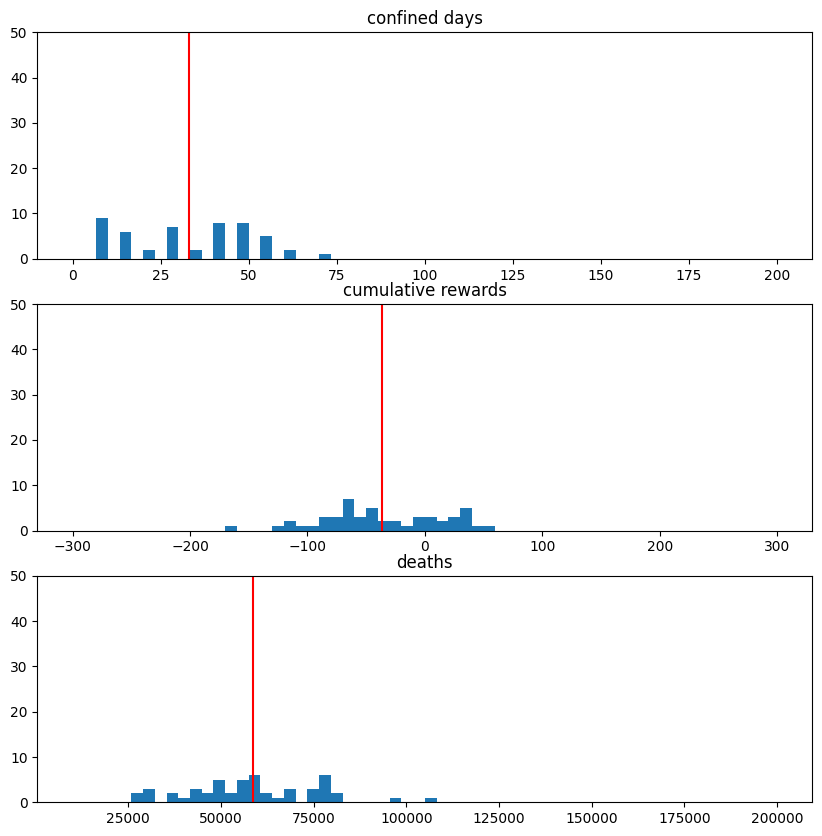

In [ ]:
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (10000,200000)
    elif title == 'cumulative rewards':
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title')
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)

agent.load_model("/content/DQ_learning/models/4_1_b.pt")
run_experiment(agent, 50, env_toggle)

### Question 4.1.d) (Theory) question about toggled-action-space policy, what assumption does it make?

**What assumptions does the use of such a technique make on the action space? Could you think of an action space for which toggling the actions would not be suitable? Discuss.**

The main assumption that we made is that any action can be taken with any another one at the same time. 

An example where this technique won't be suitable: Binary action space or spaces that have actions regarding the same attributes (Example: If we add to our action space: **Reduce** hospital beds). Considered policy will allow us to have actions to add and reduce hospital beds at the same time, which does not have much sense.

### Question 4.2.a) multi-action factorized Q-values policy training

Implementation of the multi-action factorized Q-values agent and observation spaces and training Deep Q-Learning agent on it. 

*Plots of the evaluation and training traces on a graph together with the traces from the toggle-action-space training (averaged across 3 training runs).*

In [ ]:
action_space_factorized        =   spaces.MultiBinary(4)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length), 
                                    dtype=np.float16)

def action_preprocessor_factorized(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False,
        'isolation': False,
        'hospital': False,
        'vaccinate': False,
    }
    actions = []
    for k in range(len(a)):
      if a[k] == 1:
        actions.append(k+1)
    for i in actions:
        if i == ACTION_CONFINE:
            action['confinement'] = True
        elif i == ACTION_ISOLATE:
            action['isolation'] = True
        elif i == ACTION_VACCINATE:
            action['vaccinate'] = True
        elif i == ACTION_HOSPITAL:
            action['hospital'] = True
    return action

def observation_preprocessor_factorized(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    return torch.pow(torch.Tensor(np.stack((infected, dead))).unsqueeze(0), 1/4)

env_factorized = Env(  dyn,
            action_space=action_space_factorized,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor_factorized,
            observation_preprocessor=observation_preprocessor_factorized,
            )

In [ ]:
agent = DQNAgent_Factorize(env_factorized, DQN_Factorized, lr = 1e-5)
log_eval = []
log_train = []
decreasing = True
for train in range(3):
  agent.reset()
  print("Run:", train + 1)
  for i_episode in range(1, 501):
      torch.manual_seed(0)
      torch.use_deterministic_algorithms(True)
      R_total = 0
      state, info = env_factorized.reset(i_episode)
      state = state.flatten()
      state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
      update_target = False
      if i_episode%5 ==0:
          update_target = True
      for t in count():
          action = agent.act(state, i_episode, decreasing)
          observation, reward, terminated, truncated = env_factorized.step(action)
          R_total += reward[0][0]
          reward = torch.tensor([reward], device=device)
          done = terminated or truncated
          if terminated:
              next_state = None
              break
          else:
              next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
          agent.memory.push(state, action.unsqueeze(0), next_state, reward)
          state = next_state
          agent.optimize_model(update_target)
          target_net_state_dict = agent.target_net.state_dict()
          policy_net_state_dict = agent.policy_net.state_dict()
          for key in policy_net_state_dict:
              target_net_state_dict[key] = policy_net_state_dict[key]*0.005 + target_net_state_dict[key]*(1-0.005)
          agent.target_net.load_state_dict(target_net_state_dict)
      log_train.append(R_total)
      # Evaluation
      if i_episode%50 == 0:
          print(i_episode)
          R_total = []
          rewards = -100
          agent.epsilon = 0
          for i in range(20):
              torch.manual_seed(0)
              torch.use_deterministic_algorithms(True)
              state, info = env_factorized.reset(seed = i)
              state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
              for t in count():
                  action = agent.act(state, i_episode)
                  observation, reward, terminated, truncated = env_factorized.step(action)
                  R_total.append(reward[0][0])
                  reward = torch.tensor([reward], device=device)
                  done = terminated or truncated
                  if terminated:
                      next_state = None
                      break
                  else:
                      next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
                  state = next_state
          if np.mean(R_total) >= rewards:
              rewards = np.mean(R_total)
              # saving the best model
              agent.save_model("/content/DQ_learning/models/4_2_a.pt")
          agent.epsilon = 0.7
          log_eval.append(np.mean(R_total))

Run: 1
50
100
150
200
250
300
350
400
450
500
Run: 2
50
100
150
200
250
300
350
400
450
500
Run: 3
50
100
150
200
250
300
350
400
450
500


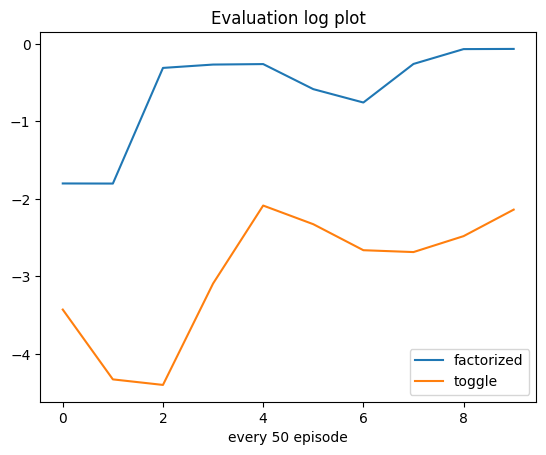

[-1.8005414  -1.8018707  -0.31094417 -0.26779082 -0.26156497 -0.58452386
 -0.75706095 -0.2598269  -0.06852048 -0.06612261]


In [ ]:
eval_log = np.array(log_eval).reshape(3, int(len(log_eval)/3)).mean(axis = 0)
plt.plot(eval_log, label = 'factorized')
plt.plot(eval_log_toggle, label='toggle')
plt.legend()
plt.title("Evaluation log plot")
plt.xlabel("every 50 episode")
plt.show();
print(eval_log)

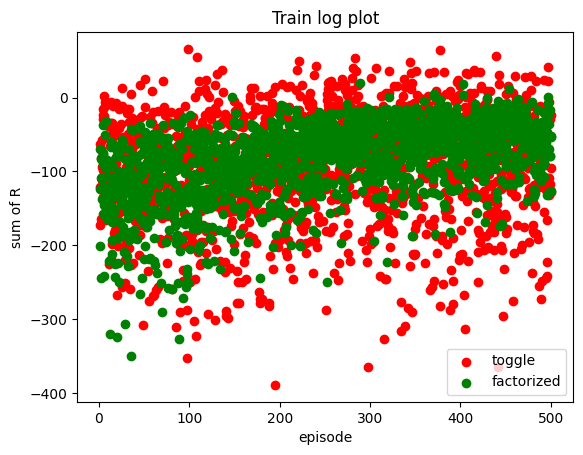

In [ ]:
train_log = np.array(log_train).reshape(3, int(len(log_train)/3))
plt.scatter(y = train_log_toggle[0], x = np.arange(1, 501), c='r', label='toggle')
plt.scatter(y = train_log_toggle[1], x = np.arange(1, 501), c='r')
plt.scatter(y = train_log_toggle[2], x = np.arange(1, 501), c='r')
plt.scatter(y = train_log[0], x = np.arange(1, 501), c='g', label='factorized')
plt.scatter(y = train_log[1], x = np.arange(1, 501), c='g')
plt.scatter(y = train_log[2], x = np.arange(1, 501), c='g')

plt.legend()
plt.title("Train log plot")
plt.xlabel("episode")
plt.ylabel("sum of R")
plt.show();

In [ ]:
agent.load_model("/content/DQ_learning/models/4_2_a.pt")
log_eval = []
log = []
for i_episode in range(1, 4):
    torch.manual_seed(0)
    torch.use_deterministic_algorithms(True)
    state, info = env_factorized.reset(i_episode)
    state = state.flatten()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    R_total = []
    agent.epsilon = 0
    for t in count():
        action = agent.act(state, i_episode)
        observation, reward, terminated, truncated = env_factorized.step(action)
        if i_episode == 2:
          log.append(truncated)
        R_total.append(reward[0][0])
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
            break
        else:
            next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
        state = next_state
    log_eval.append(np.mean(R_total))

total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

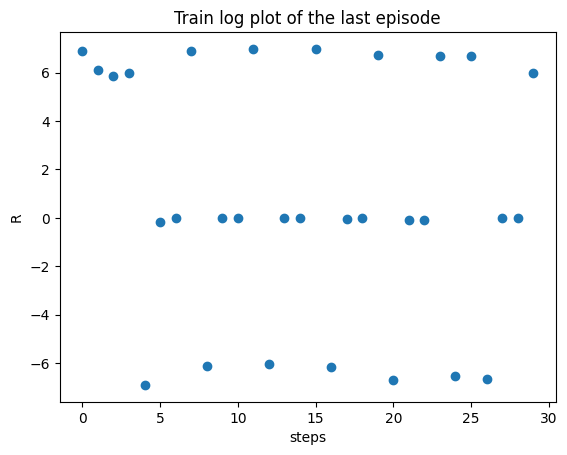

In [ ]:
plt.scatter(x = np.arange(len(R_total)), y = R_total)
plt.title("Train log plot of the last episode")
plt.xlabel("steps")
plt.ylabel("R")
plt.show();

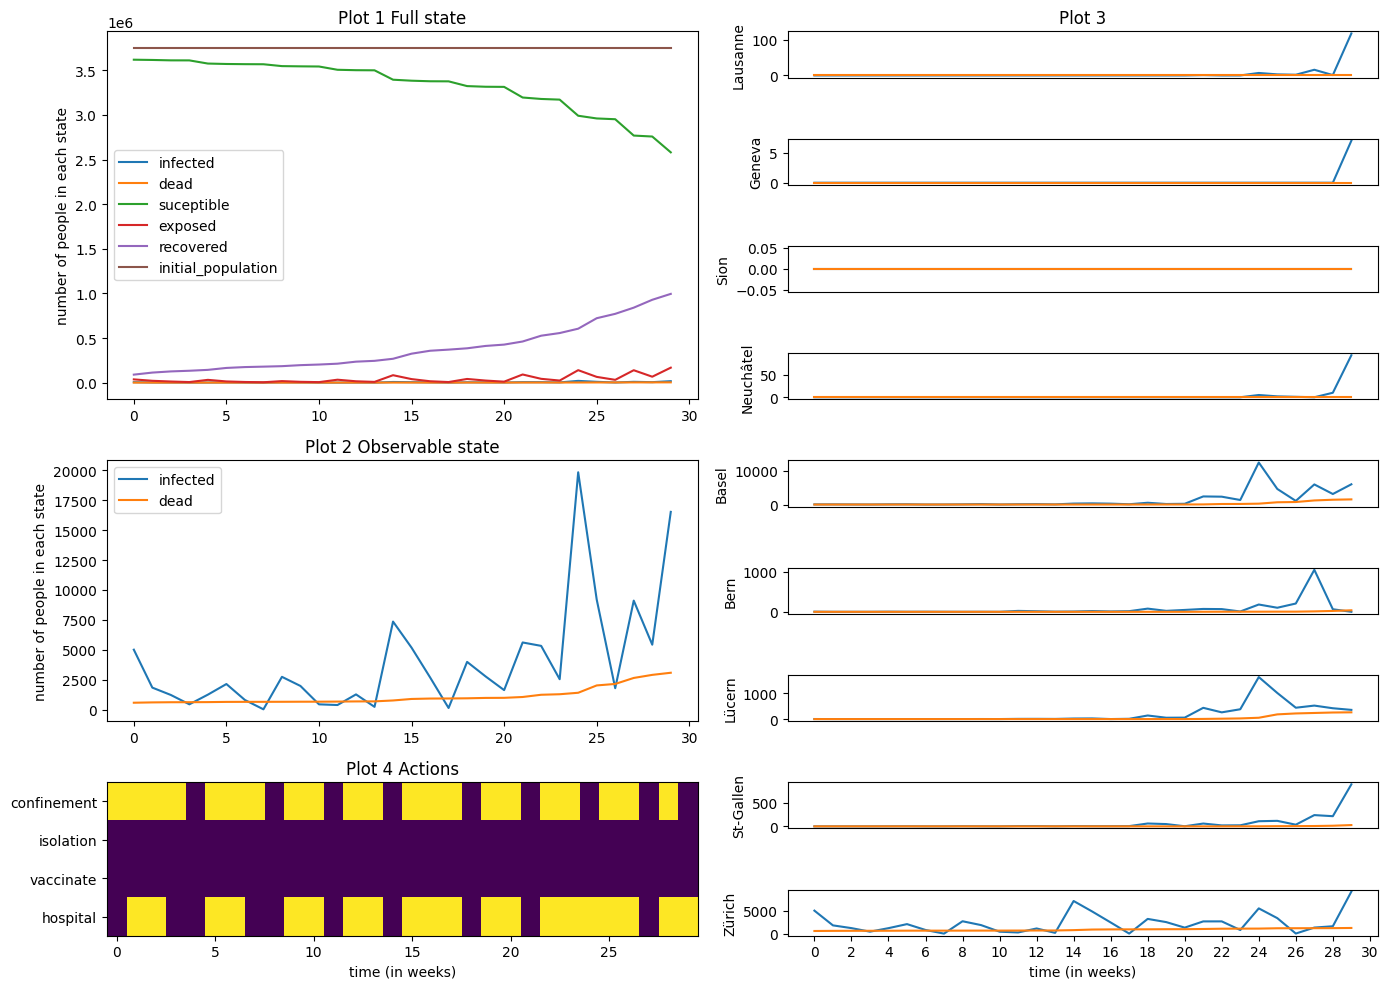

In [ ]:
plot_all(leftstate = True, leftobs =True, leftactions = True, right_per_city = True, order = [1, 2, 4, 3])

### Question 4.2.b) multi-action factorized Q-values policy evaluation

Evaluation of the best policy $\pi^{*}_{factor}$ trained in question 4.2.a), using the evaluation procedure that we previously defined. 

*Plot of the histograms is below.*

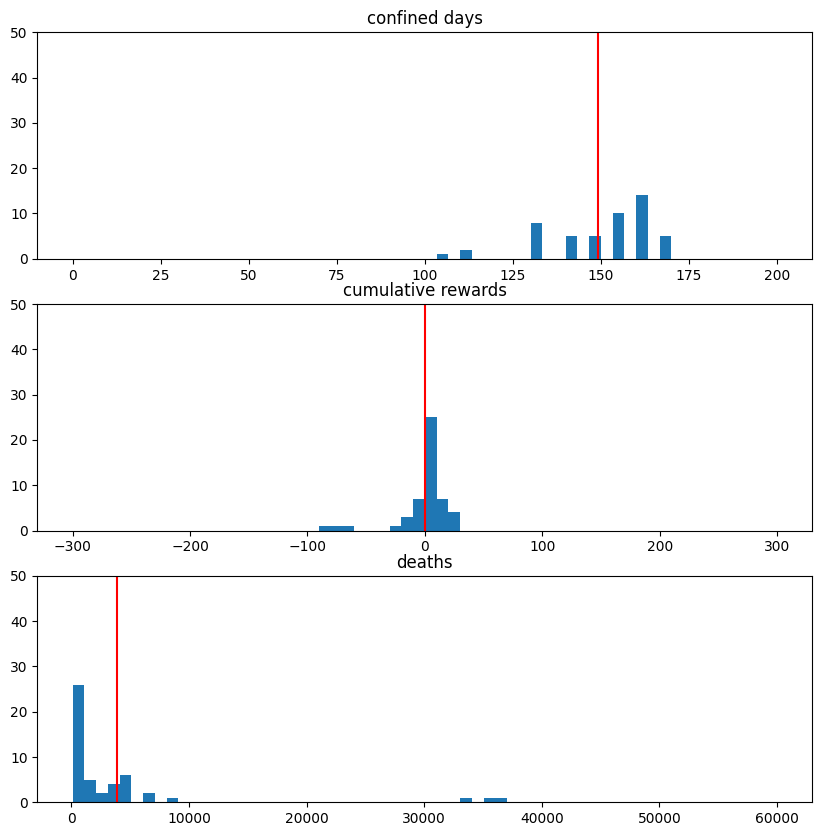

In [ ]:
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (100,60000)
    elif title == 'cumulative rewards':
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title')
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)

agent.load_model("/content/DQ_learning/models/4_2_a.pt")
run_experiment(agent, 50, env_factorized)

### Question 4.2.c) (Theory) Factorized-Q-values, what assumption does it make?

**In question 4.2.a), you implemented a factorized-Q-value policy. What assumptions does the use of such a technique make on the action space? Could you think of an action space for which factorizing Q-values would not be suitable? Discuss.**

For the factorized-Q-value policy, we assume that actions are independent. In the estimating final q-value we need the union of all q-values of all chosen actions, but for practical purposes knowing that they are independent, we just sum them up). An example where this technique won't be suitable: Having dependent(overlapped) actions: Add beds to all hospitals and add beds to those hospitals that have expertise in treating infections.

## Wrapping Up

### Question 5.a) (Result analysis) Comparing the training behaviors

**Compare the evaluations and training curves of Pr. Russo’s Policy, single-action DQN, factorized Q-values and toggled-action-space policies. Discuss the performance differences, what do you observe? How do the two approaches compare? What approach performs best? Why?**


Looking at evaluations, we can see that Russo's policy performs quite poorly. But also, we observe that one Q-values based approach doesn't have also much success - with toggled action space. However, worth to notice, other DQN policies managed get quite good results. The first approach is implemented statically, but Q-values based policies aim to estimate Q-values of each action in each state. What we can conclude, that all DQN outperform Russo policy. Looking at the reward, we can conclude that binary DQN is the best policy.

### Question 5.b) (Result analysis) Comparing policies
Run the evaluation procedure with each ($\pi_{DQN}$, $\pi_{toggle}$, $\pi_{factor}$ as well as the original $\pi_{russo}$) trained policy (always pick the best-performing policy) for 50 episode and compute the following metrics (all of the averages are empirical means computed over the 50 episodes):

1. the average number of total confined days avg[$N_{confinement}$] (lower is better),
2. the average number of total isolation days avg[$N_{isolation}$] (lower is better),
3. the average number of total vaccination days avg[$N_{vaccination}$] (lower is better),
4. the average number of total additional hospital bed days avg[$N_{hospital}$] (lower is better),
5. the average number of total deaths avg[$N_{deaths}$] (lower is better),
6. the average cumulative reward avg[$R_{cumulative}$] (higer is better).

Make a table with each of those values for each policy. Clearly mark the best performing policy with respect to
each metric. Exclude the policies that do not have access to an action from the relevant metric (for instance, as
πRusso does not have access to vaccination, exclude it from the total vaccination days comparaison).

In [ ]:
def run_experiments(agent, num_episodes, env, russo = False):
    rewards = []
    confine = []
    hospitality = []
    isolate = []
    vaccination = []

    death = []
    for trace in range(num_episodes):
        torch.manual_seed(0)
        torch.use_deterministic_algorithms(True)
        log = []
        seed = trace
        finished = False
        obs, info = env.reset(seed)
        agent.reset()
        if not russo:
          agent.epsilon = 0
        n_weeks_confined = 0
        n_weeks_hospital = 0
        n_weeks_isolation = 0
        n_weeks_vaccinate = 0
        R_sum = 0
        while not finished:
            if russo:
                action = agent.act(obs)
            else: 
                action = agent.act(obs.flatten().unsqueeze(0), trace)
            obs, R, finished, info = env.step(action)
            log.append(info)
            R_sum += R[0][0]
            if dyn.get_action()["confinement"]:
              n_weeks_confined += 1
            if dyn.get_action()["hospital"]:
              n_weeks_hospital += 1
            if dyn.get_action()["isolation"]:
              n_weeks_isolation += 1
            if dyn.get_action()["vaccinate"]:
              n_weeks_vaccinate += 1
            if finished:
                break
        """ Parse the logs """
        total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
        confine.append(7*n_weeks_confined) 
        hospitality.append(7*n_weeks_hospital)
        isolate.append(7*n_weeks_isolation)
        vaccination.append(7*n_weeks_vaccinate)
        rewards.append(R_sum)
        death.append(total['dead'][-1])
    return np.mean(confine), np.mean(isolate), np.mean(vaccination), np.mean(hospitality), np.mean(death), np.mean(rewards)

In [ ]:
agent_russo = RussoAgent(env)
c_russo, i_russo, v_russo, h_russo, d_russo, r_russo = run_experiments(agent_russo, 50, env, True)
agent_dqn = DQNAgent(env_dqn, DQN)
agent_dqn.load_model("/content/DQ_learning/models/3_b.pt")
c_dqn, i_dqn, v_dqn, h_dqn, d_dqn, r_dqn = run_experiments(agent_dqn, 50, env_dqn)
agent_toggle = DQNAgent(env_toggle, DQN, lr = 1e-5)
agent_toggle.load_model("/content/DQ_learning/models/4_1_b.pt")
c_toggle, i_toggle, v_toggle, h_toggle, d_toggle, r_toggle = run_experiments(agent_toggle, 50, env_toggle)
agent_factorized = DQNAgent_Factorize(env_factorized, DQN_Factorized, lr = 1e-5)
agent_factorized.load_model("/content/DQ_learning/models/4_2_a.pt")
c_factorized, i_factorized, v_factorized, h_factorized, d_factorized, r_factorized = run_experiments(agent_factorized, 50, env_factorized)

print("\begin{tabular}{|c|c|c|c|}")
print("\hline")
print(" & avg[$N_{confinement}$] & avg[$N_{isolation}$] & avg[$N_{vaccination}$] & avg[$N_{hospital}$] & avg[$N_{deaths}$] & avg[$R_{cumulative}$] \\")
print("\hline")
print("Russo & {} & {} & {} & {} & {} & {} \\".format(c_russo, i_russo, v_russo, h_russo, d_russo, r_russo))
print("DQN & {} & {} & {} & {} & {} & {} \\".format(c_dqn, i_dqn, v_dqn, h_dqn, d_dqn, r_dqn))
print("Toggle & {} & {} & {} & {} & {} & {} \\".format(c_toggle, i_toggle, v_toggle, h_toggle, d_toggle, r_toggle))
print("Factorized & {} & {} & {} & {} & {} & {} \\".format(c_factorized, i_factorized, v_factorized, h_factorized, d_factorized, r_factorized))
print("\hline")
print("\end{tabular}")

egin{tabular}{|c|c|c|c|}
\hline
 & avg[$N_{confinement}$] & avg[$N_{isolation}$] & avg[$N_{vaccination}$] & avg[$N_{hospital}$] & avg[$N_{deaths}$] & avg[$R_{cumulative}$] \
\hline
Russo & 100.24 & 0.0 & 0.0 & 0.0 & 58071.94 & -69.96265411376953 \
DQN & 149.38 & 0.0 & 0.0 & 0.0 & 6113.82 & 39.3799934387207 \
Toggle & 33.18 & 0.0 & 103.88 & 54.46 & 58697.28 & -36.452796936035156 \
Factorized & 149.24 & 0.0 & 0.0 & 136.92 & 3917.36 & 0.4189796447753906 \
\hline
\end{tabular}


### Question 5.c) (Interpretability) Q-values
For both $\pi_{DQN}$ and $\pi_{factor}$, run a
simulation episode, and plot a heat-map of the evolution of all Q-values with time, with action selections in the y-axis and time (in weeks) in the x axis.

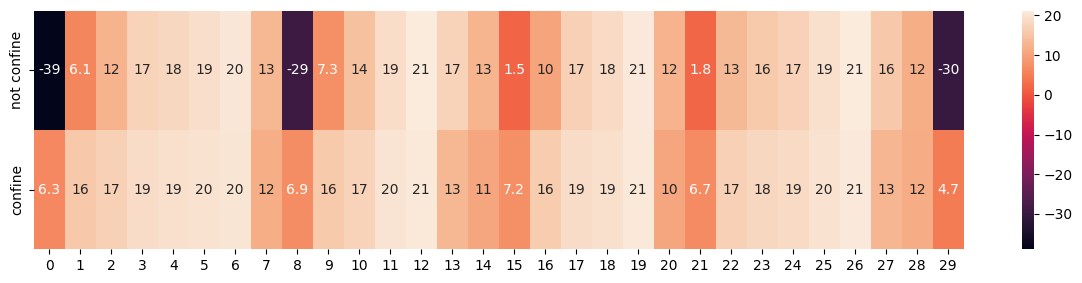

In [ ]:
def simulate(agent, env):
  trace = 1
  torch.manual_seed(0)
  torch.use_deterministic_algorithms(True)
  log = []
  seed = trace
  finished = False
  obs, info = env.reset(seed)
  agent.reset()
  agent.epsilon = 0
  while not finished:
      log.append(agent.policy_net(obs.flatten().unsqueeze(0))[0].detach().numpy())
      action = agent.act(obs.flatten().unsqueeze(0), trace)
      obs, R, finished, info = env.step(action)
  return log 

fig, ax = plt.subplots(figsize=(15, 3.1))
q_values = np.array(simulate(agent_dqn, env_dqn)).T
yticks = range(0, 30)
ax = sns.heatmap(q_values, annot=True, xticklabels=yticks)
ax.set_yticklabels(['not confine', 'confine'])
plt.show();

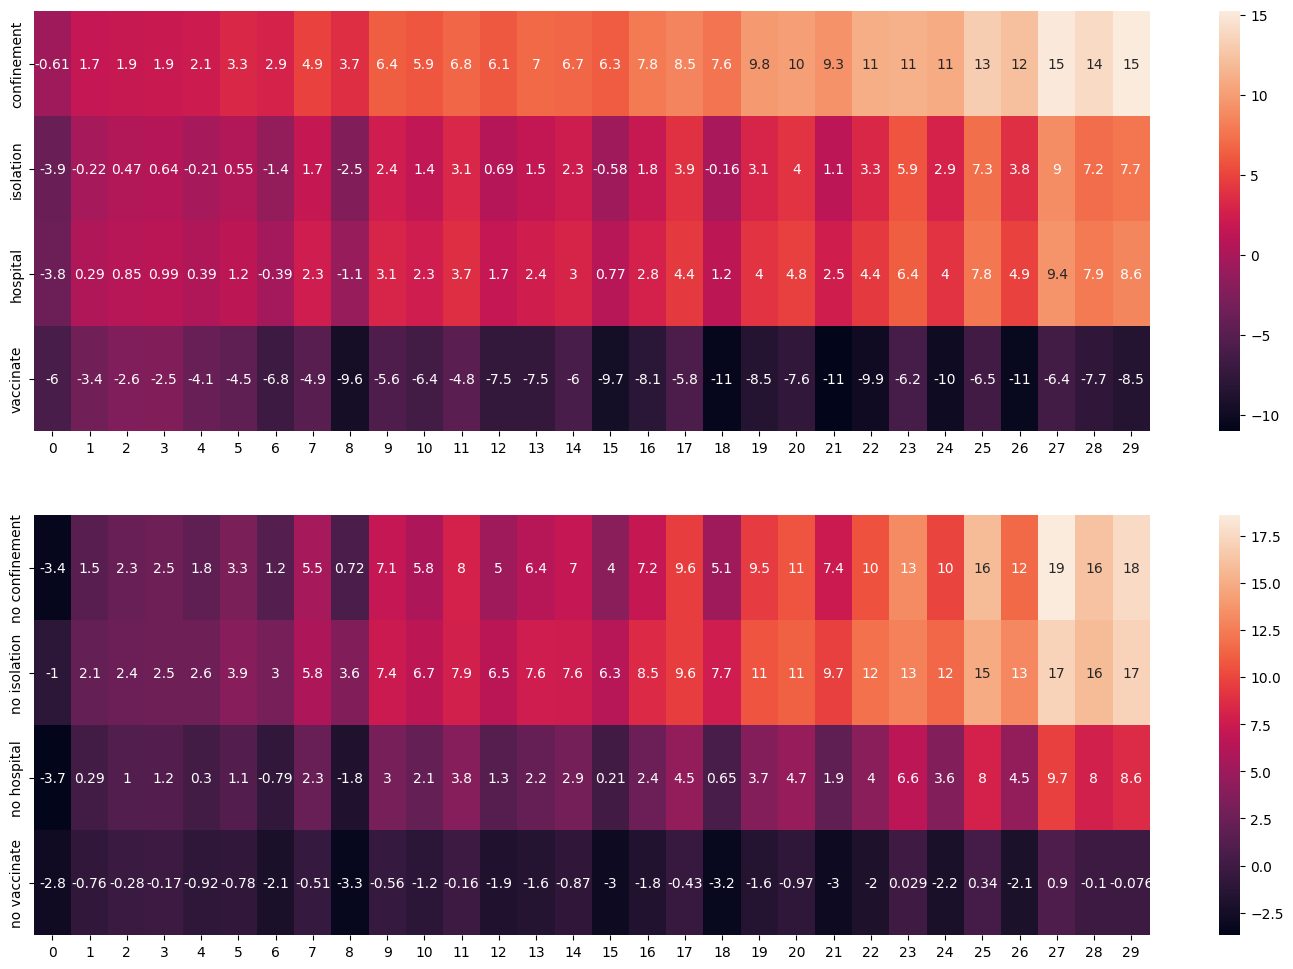

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
q_values = np.array(simulate(agent_factorized, env_factorized))
q_true = q_values[:, :, 1].T
q_false = q_values[:, :, 0].T
yticks = range(0, 30)
sns.heatmap(q_true, annot=True, xticklabels=yticks, ax=ax[0])
ax[0].set_yticklabels(['confinement', 'isolation', 'hospital', 'vaccinate'])
sns.heatmap(q_false, annot=True, xticklabels=yticks, ax=ax[1])
ax[1].set_yticklabels(['no confinement', 'no isolation', 'no hospital', 'no vaccinate'])
plt.show();

### Question 5.d) (Theory), Is cumulative reward an increasing function of the number of actions?
**In the following project you have implemented different policies acting on the exact same environment with a
different number of actions. Is cumulative reward an increasing function of the number of actions?
(In other words, does adding an action always yield a better reward?)**

Taking into the account the results of toggled-action space policy (binary DQN has higher average reward), we can conclude that cumulative reward is not always the increasing function of the number of actions.

## Additional code

### **DQ_learning/model.py**

In [ ]:
import torch
import torch.nn as nn
from torch._tensor import Tensor
from typing import Tuple
import torch.nn.functional as F

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)


class DQN_Factorized(nn.Module):
    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 4*2)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        y = self.layer4(x).view(-1, 4, 2)
        return y

### **DQ_learning/agent.py**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import namedtuple, deque
from abc import ABC, abstractmethod
from typing import Tuple
from epidemic_env.env import Env


Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class Agent(ABC):
    """Implements acting and learning. (Abstract class, for implementations see DQNAgent and NaiveAgent).

    Args:
        ABC (_type_): _description_

    Returns:
        _type_: _description_
    """
    @abstractmethod
    def __init__(self,  env, *args, **kwargs):
        """
        Args:
            env (_type_): the simulation environment
        """
        
    @abstractmethod
    def load_model(self, savepath:str):
        """Loads weights from a file.

        Args:
            savepath (str): path at which weights are saved.
        """
        
    @abstractmethod
    def save_model(self, savepath:str):
        """Saves weights to a specified path

        Args:
            savepath (str): the path
        """
        
    @abstractmethod
    def optimize_model(self)->float:
        """Perform one optimization step.

        Returns:
            float: the loss
        """
    
    @abstractmethod
    def reset():
        """Resets the agent's inner state
        """
        
    @abstractmethod 
    def act(self, obs:torch.Tensor)->Tuple[int, float]:
        """Selects an action based on an observation.

        Args:
            obs (torch.Tensor): an observation

        Returns:
            Tuple[int, float]: the selected action (as an int) and associated Q/V-value as a float
        """


class DQNAgent(Agent):
    def __init__(self,  env:Env,
                 model:torch.nn,
                 criterion=nn.SmoothL1Loss(),
                 lr:float=5e-3,
                 epsilon:float=0.7,
                 gamma:float=0.9,
                 buffer_size:int=20000,
                 batch_size:int=2048,
                 n_episodes:int=500, 
                 epsilon_min:float=0.3)->None:

        self.env = env

        model_params = {
            'n_observations': len(env.observation_space.sample().flatten()),
            'n_actions': env.action_space.n,
        }
        
        self.policy_net = model(**model_params)
        self.target_net = model(**model_params)
        # self.target_net.load_state_dict(self.policy_net.state_dict())

        self.criterion = criterion
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=lr, amsgrad=True)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.memory = ReplayMemory(buffer_size)
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        self.lr = lr
        self.T_max = n_episodes

    def load_model(self, savepath:str): 
        self.policy_net.load_state_dict(torch.load(savepath))

    def save_model(self, savepath:str):
        torch.save(self.policy_net.state_dict(), savepath)

    def optimize_model(self, update = True):
        if len(self.memory) < self.batch_size:
                return np.double(0)
        transitions = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        if update: 
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        else: 
            with torch.no_grad():
                next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute Huber loss
        loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        return loss

    def reset(self):
        pass

    def act(self, state, time, decreasing = False):
        epsilon = self.epsilon
        if decreasing:
            epsilon = max(self.epsilon * (self.T_max - time) / self.T_max, self.epsilon_min)
        sample = random.random()
        if sample > epsilon:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=self.device, dtype=torch.long)
        
        
        
class DQNAgent_Factorize(Agent):
    def __init__(self,  env:Env,
                 model:torch.nn,
                 criterion=nn.SmoothL1Loss(),
                 lr:float=5e-3,
                 epsilon:float=0.7,
                 gamma:float=0.9,
                 buffer_size:int=20000,
                 batch_size:int=2048,
                 n_episodes:int=500, 
                 epsilon_min:float=0.3)->None:

        self.env = env
        
        model_params = {
            'n_observations': len(env.observation_space.sample().flatten()),
            'n_actions': 4*2,
        }
        
        self.policy_net = model(**model_params)
        self.target_net = model(**model_params)
        # self.target_net.load_state_dict(self.policy_net.state_dict())

        self.criterion = criterion
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=lr, amsgrad=True)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.memory = ReplayMemory(buffer_size)
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        self.lr = lr
        self.T_max = n_episodes

    def load_model(self, savepath:str): 
        self.policy_net.load_state_dict(torch.load(savepath))

    def save_model(self, savepath:str):
        torch.save(self.policy_net.state_dict(), savepath)

    def optimize_model(self, update = True):
        if len(self.memory) < self.batch_size:
                return np.double(0)
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        # action_batch = torch.cat(batch.action)
        action_batch = torch.cat([e for e in batch.action], axis=0)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = torch.sum(self.policy_net(state_batch).gather(2, action_batch.unsqueeze(2)), axis=1)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        if update: 
            next_state_values[non_final_mask] = torch.sum(self.target_net(non_final_next_states).max(2)[0], axis=1)
        else: 
            with torch.no_grad():
                next_state_values[non_final_mask] = torch.sum(self.target_net(non_final_next_states).max(2)[0], axis=1)
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute Huber loss
        loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        return loss

    def reset(self):
        pass

    def act(self, state, time, decreasing = False):
        epsilon = self.epsilon
        if decreasing:
            epsilon = max(self.epsilon * (self.T_max - time) / self.T_max, self.epsilon_min)
        sample = random.random()
        if sample > epsilon:
            with torch.no_grad():
                output = torch.argmax(self.policy_net(state)[0], axis = 1)
                return output.to(dtype=torch.int64)
        else:
            action = self.env.action_space.sample()
            return torch.tensor(action, device=self.device).to(dtype=torch.int64)